## This notebook is provided to show how we generate the filtered peakxmotif anndata. The interpretation h5 files are very large, and as a result, we will only be able to provide them upon request.

Final output peakxmotif anndata are provided in FilteredMotifHits folder. 

In [ ]:
!pip install plotnine
!conda install -c bioconda anndata -y

In [ ]:
import os
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyfaidx
from collections import Counter, defaultdict, OrderedDict
import logomaker
from copy import deepcopy
from tqdm import tqdm
from tqdm import tnrange
import deepdish
import pyBigWig
import tqdm
import sys
import pyfaidx
import pysam
sys.path.append("../../../chrombpnet/")
from training.utils.losses import multinomial_nll
from training.utils.one_hot import dna_to_one_hot
from evaluation.interpret.shap_utils import *
import h5py
import hdf5plugin
import shap
import glob
tf.compat.v1.disable_eager_execution()
import scipy.stats
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import pyBigWig
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
import sys
sys.path.append("../../../src/")
custom_objects={"tf":tf, "multinomial_nll":multinomial_nll}    
get_custom_objects().update(custom_objects)
from tensorflow import keras
from plotnine import *
import anndata

In [3]:
def motif_filtration(shap_shuf_h5path, shap_h5path, motif_hit_tsv_path, peak_tsv_path, unfiltered_tsv_path,filtration_thres,filtered_tsv_path):
    shap_shuf_path = shap_shuf_h5path
    shap_shuf_file = h5py.File(shap_shuf_path,"r")
    shap_shuf_scores = shap_shuf_file['projected_shap']['seq'][:]
    shap_shuf_scores = shap_shuf_scores.transpose(0,2,1)

    shap_path = shap_h5path
    shap_file = h5py.File(shap_path,"r")
    shap_scores = shap_file['projected_shap']['seq'][:]
    shap_scores = shap_scores.transpose(0,2,1) 

    peak_motif = pd.read_csv(motif_hit_path, sep="\t")
    all_peaks = pd.read_csv(peak_tsv_path,sep="\t",header=None)
    all_peaks.columns = ['peak_chrom','peak_start','peak_end','Peak_index','score','strand','X','Y','Z','summit']
    all_peaks = all_peaks[['peak_chrom','peak_start','peak_end','summit']]

    peak_motif_merged = pd.merge(peak_motif,all_peaks,how = "left",on=["peak_chrom","peak_start","peak_end"])
    peak_motif_merged['motif_rel_start_new'] = peak_motif_merged['motif_rel_start']-peak_motif_merged['summit']+1057
    peak_motif_merged['motif_rel_end_new'] = peak_motif_merged['motif_rel_end']-peak_motif_merged['summit']+1057

    sum_motif = np.empty(len(peak_motif))
    mean_motif = np.empty(len(peak_motif))
    sum_null = np.empty(len(peak_motif))
    mean_null = np.empty(len(peak_motif))
    sum_motif_norm = np.empty(len(peak_motif))
    mean_motif_norm = np.empty(len(peak_motif))
    sum_null_norm = np.empty(len(peak_motif))
    mean_null_norm = np.empty(len(peak_motif))

    for peak_index, group in peak_motif_merged.groupby("peak_index"):
        score_track_null = (shap_shuf_scores[peak_index])
        score_track_obs = (shap_scores[peak_index])
    
        for i, row in group.iterrows():
            shap_null = score_track_null[row["motif_rel_start_new"]:row["motif_rel_end_new"]]
            shap_obs = score_track_obs[row["motif_rel_start_new"]:row["motif_rel_end_new"]]
            sum_null[i] = np.sum(shap_null)
            mean_null[i] = np.mean(shap_null)
            sum_motif[i] = np.sum(shap_obs)
            mean_motif[i] = np.mean(shap_obs)
            sum_null_norm[i] = sum_null[i]/np.mean(score_track_null)
            mean_null_norm[i] = mean_null[i]/np.mean(score_track_null)
            sum_motif_norm[i] = sum_motif[i]/np.mean(score_track_obs)
            mean_motif_norm[i] = mean_motif[i]/np.mean(score_track_obs)
    
    peak_motif_merged["motif_sum"] = sum_motif 
    peak_motif_merged["motif_mean"] = mean_motif
    peak_motif_merged["null_sum"] = sum_null 
    peak_motif_merged["null_mean"] = mean_null

    peak_motif_merged["motif_sum_norm"] = sum_motif_norm 
    peak_motif_merged["motif_mean_norm"] = mean_motif_norm
    peak_motif_merged["null_sum_norm"] = sum_null_norm 
    peak_motif_merged["null_mean_norm"] = mean_null_norm

    peak_motif_merged.to_csv(unfiltered_tsv_path,sep="\t",index = None)

    # Now, let's put threshold and see what we recover 
    active_thresh = filtration_thres

    active_motifs = peak_motif_merged.loc[(peak_motif_merged['motif_mean'] >= peak_motif_merged['null_mean'].quantile(active_thresh))].reset_index(drop=True).copy() #| 
                               #(peak_motif['motif_mean'] <= np.quantile(null_bp_scores, 1 - active_thresh))].reset_index(drop=True).copy()

    print(peak_motif_merged['null_mean'].quantile(active_thresh))

    display(active_motifs.head(20))
    display(active_motifs.shape)

    active_motifs.to_csv(filtered_tsv_path,sep="\t",index = None)
    return active_motifs

In [3]:
def motif_filtration_bulk(shap_shuf_h5path_1, shap_h5path_1,shap_shuf_h5path_2, shap_h5path_2, motif_hit_tsv_path, peak_tsv_path, unfiltered_tsv_path,filtration_thres,filtered_tsv_path):
    shap_shuf_path_1 = shap_shuf_h5path_1
    shap_shuf_file_1 = h5py.File(shap_shuf_path_1,"r")
    shap_shuf_scores_1 = shap_shuf_file_1['projected_shap']['seq'][:]
    shap_shuf_scores_1 = shap_shuf_scores_1.transpose(0,2,1)

    shap_shuf_path_2 = shap_shuf_h5path_2
    shap_shuf_file_2 = h5py.File(shap_shuf_path_2,"r")
    shap_shuf_scores_2 = shap_shuf_file_2['projected_shap']['seq'][:]
    shap_shuf_scores_2 = shap_shuf_scores_2.transpose(0,2,1)

    shap_path_1 = shap_h5path_1
    shap_file_1 = h5py.File(shap_path_1,"r")
    shap_scores_1 = shap_file_1['projected_shap']['seq'][:]
    shap_scores_1 = shap_scores_1.transpose(0,2,1)

    shap_path_2 = shap_h5path_2
    shap_file_2 = h5py.File(shap_path_2,"r")
    shap_scores_2 = shap_file_2['projected_shap']['seq'][:]
    shap_scores_2 = shap_scores_2.transpose(0,2,1)

    shap_shuf_scores = np.mean(np.array([shap_shuf_scores_1,shap_shuf_scores_2]), axis=0)
    shap_scores = np.mean(np.array([shap_scores_1,shap_scores_2]), axis=0)


    peak_motif = pd.read_csv(motif_hit_path, sep="\t")
    all_peaks = pd.read_csv(peak_tsv_path,sep="\t",header=None)
    all_peaks.columns = ['peak_chrom','peak_start','peak_end','Peak_index','score','strand','X','Y','Z','summit']
    all_peaks = all_peaks[['peak_chrom','peak_start','peak_end','summit']]

    peak_motif_merged = pd.merge(peak_motif,all_peaks,how = "left",on=["peak_chrom","peak_start","peak_end"])
    peak_motif_merged['motif_rel_start_new'] = peak_motif_merged['motif_rel_start']-peak_motif_merged['summit']+1057
    peak_motif_merged['motif_rel_end_new'] = peak_motif_merged['motif_rel_end']-peak_motif_merged['summit']+1057

    sum_motif = np.empty(len(peak_motif))
    mean_motif = np.empty(len(peak_motif))
    sum_null = np.empty(len(peak_motif))
    mean_null = np.empty(len(peak_motif))
    sum_motif_norm = np.empty(len(peak_motif))
    mean_motif_norm = np.empty(len(peak_motif))
    sum_null_norm = np.empty(len(peak_motif))
    mean_null_norm = np.empty(len(peak_motif))

    for peak_index, group in peak_motif_merged.groupby("peak_index"):
        score_track_null = (shap_shuf_scores[peak_index])
        score_track_obs = (shap_scores[peak_index])
    
        for i, row in group.iterrows():
            shap_null = score_track_null[row["motif_rel_start_new"]:row["motif_rel_end_new"]]
            shap_obs = score_track_obs[row["motif_rel_start_new"]:row["motif_rel_end_new"]]
            sum_null[i] = np.sum(shap_null)
            mean_null[i] = np.mean(shap_null)
            sum_motif[i] = np.sum(shap_obs)
            mean_motif[i] = np.mean(shap_obs)
            sum_null_norm[i] = sum_null[i]/np.mean(score_track_null)
            mean_null_norm[i] = mean_null[i]/np.mean(score_track_null)
            sum_motif_norm[i] = sum_motif[i]/np.mean(score_track_obs)
            mean_motif_norm[i] = mean_motif[i]/np.mean(score_track_obs)
    
    peak_motif_merged["motif_sum"] = sum_motif 
    peak_motif_merged["motif_mean"] = mean_motif
    peak_motif_merged["null_sum"] = sum_null 
    peak_motif_merged["null_mean"] = mean_null

    peak_motif_merged["motif_sum_norm"] = sum_motif_norm 
    peak_motif_merged["motif_mean_norm"] = mean_motif_norm
    peak_motif_merged["null_sum_norm"] = sum_null_norm 
    peak_motif_merged["null_mean_norm"] = mean_null_norm

    peak_motif_merged.to_csv(unfiltered_tsv_path,sep="\t",index = None)

    # Now, let's put threshold and see what we recover 
    active_thresh = filtration_thres

    active_motifs = peak_motif_merged.loc[(peak_motif_merged['motif_mean'] >= peak_motif_merged['null_mean'].quantile(active_thresh))].reset_index(drop=True).copy() #| 
                               #(peak_motif['motif_mean'] <= np.quantile(null_bp_scores, 1 - active_thresh))].reset_index(drop=True).copy()

    print(peak_motif_merged['null_mean'].quantile(active_thresh))

    display(active_motifs.head(20))
    display(active_motifs.shape)

    active_motifs.to_csv(filtered_tsv_path,sep="\t",index = None)
    return active_motifs

## M. lignano

In [ ]:
## cathepsin 
cathepsin_filtered_motifs = motif_filtration('../../Mlig_BPnet/chrombpnet_model/celltype/cathepsin/interpret_null/corrected.counts_scores.h5', 
                                             '../../Mlig_BPnet/chrombpnet_model/celltype/cathepsin/interpret_all/corrected.counts_scores.h5', 
                                             '../../motif_filtration/Mlig.peak_Motifhits_20230130.tsv', 
                                             '../../Mlig_BPnet/itoverlap.overlap_peaks_20220715.narrowPeak', 
                                             '../../motif_filtration/Mlig/cathepsin_motifs_SHAP.tsv',
                                             0.97,
                                             '../../motif_filtration/Mlig/cathepsin_mean_motifs_SHAP_filtered_97.tsv')

#epidermal 
epidermal_filtered_motifs = motif_filtration('../../Mlig_BPnet/chrombpnet_model/celltype/epidermal/interpret_null/corrected.counts_scores.h5', 
                                             '../../Mlig_BPnet/chrombpnet_model/celltype/epidermal/interpret_all/corrected.counts_scores.h5', 
                                             '../../motif_filtration/Mlig.peak_Motifhits_20230130.tsv', 
                                             '../../Mlig_BPnet/itoverlap.overlap_peaks_20220715.narrowPeak', 
                                             '../../motif_filtration/Mlig/epidermal_motifs_SHAP.tsv',
                                             0.97,
                                             '../../motif_filtration/Mlig/epidermal_mean_motifs_SHAP_filtered_97.tsv')

#germline 
germline_filtered_motifs = motif_filtration('../../Mlig_BPnet/chrombpnet_model/celltype/germline/interpret_null/corrected.counts_scores.h5', 
                                             '../../Mlig_BPnet/chrombpnet_model/celltype/germline/interpret_all/corrected.counts_scores.h5', 
                                             '../../motif_filtration/Mlig.peak_Motifhits_20230130.tsv', 
                                             '../../Mlig_BPnet/itoverlap.overlap_peaks_20220715.narrowPeak', 
                                             '../../motif_filtration/Mlig/germline_motifs_SHAP.tsv',
                                             0.97,
                                             '../../motif_filtration/Mlig/germline_mean_motifs_SHAP_filtered_97.tsv')

#GSC
GSC_filtered_motifs = motif_filtration('../../Mlig_BPnet/chrombpnet_model/celltype/GSC/interpret_null/corrected.counts_scores.h5', 
                                             '../../Mlig_BPnet/chrombpnet_model/celltype/GSC/interpret_all/corrected.counts_scores.h5', 
                                             '../../motif_filtration/Mlig.peak_Motifhits_20230130.tsv', 
                                             '../../Mlig_BPnet/itoverlap.overlap_peaks_20220715.narrowPeak', 
                                             '../../motif_filtration/Mlig/GSC_motifs_SHAP.tsv',
                                             0.97,
                                             '../../motif_filtration/Mlig/GSC_mean_motifs_SHAP_filtered_97.tsv')

#intestine 
intestine_filtered_motifs = motif_filtration('../../Mlig_BPnet/chrombpnet_model/celltype/intestine/interpret_null/corrected.counts_scores.h5', 
                                             '../../Mlig_BPnet/chrombpnet_model/celltype/intestine/interpret_all/corrected.counts_scores.h5', 
                                             '../../motif_filtration/Mlig.peak_Motifhits_20230130.tsv', 
                                             '../../Mlig_BPnet/itoverlap.overlap_peaks_20220715.narrowPeak', 
                                             '../../motif_filtration/Mlig/intestine_motifs_SHAP.tsv',
                                             0.97,
                                             '../../motif_filtration/Mlig/intestine_mean_motifs_SHAP_filtered_97.tsv')

#muscle
muscle_filtered_motifs = motif_filtration('../../Mlig_BPnet/chrombpnet_model/celltype/muscle/interpret_null/corrected.counts_scores.h5', 
                                             '../../Mlig_BPnet/chrombpnet_model/celltype/muscle/interpret_all/corrected.counts_scores.h5', 
                                             '../../motif_filtration/Mlig.peak_Motifhits_20230130.tsv', 
                                             '../../Mlig_BPnet/itoverlap.overlap_peaks_20220715.narrowPeak', 
                                             '../../motif_filtration/Mlig/muscle_motifs_SHAP.tsv',
                                             0.97,
                                             '../../motif_filtration/Mlig/muscle_mean_motifs_SHAP_filtered_97.tsv')

#neoblast
neoblast_filtered_motifs = motif_filtration('../../Mlig_BPnet/chrombpnet_model/celltype/neoblast/interpret_null/corrected.counts_scores.h5', 
                                             '../../Mlig_BPnet/chrombpnet_model/celltype/neoblast/interpret_all/corrected.counts_scores.h5', 
                                             '../../motif_filtration/Mlig.peak_Motifhits_20230130.tsv', 
                                             '../../Mlig_BPnet/itoverlap.overlap_peaks_20220715.narrowPeak', 
                                             '../../motif_filtration/Mlig/neoblast_motifs_SHAP.tsv',
                                             0.97,
                                             '../../motif_filtration/Mlig/neoblast_mean_motifs_SHAP_filtered_97.tsv')

#neural 
neural_filtered_motifs = motif_filtration('../../Mlig_BPnet/chrombpnet_model/celltype/neural/interpret_null/corrected.counts_scores.h5', 
                                             '../../Mlig_BPnet/chrombpnet_model/celltype/neural/interpret_all/corrected.counts_scores.h5', 
                                             '../../motif_filtration/Mlig.peak_Motifhits_20230130.tsv', 
                                             '../../Mlig_BPnet/itoverlap.overlap_peaks_20220715.narrowPeak', 
                                             '../../motif_filtration/Mlig/neural_motifs_SHAP.tsv',
                                             0.97,
                                             '../../motif_filtration/Mlig/neural_mean_motifs_SHAP_filtered_97.tsv')

#parenchyma
parenchyma_filtered_motifs = motif_filtration('../../Mlig_BPnet/chrombpnet_model/celltype/parenchyma/interpret_null/corrected.counts_scores.h5', 
                                             '../../Mlig_BPnet/chrombpnet_model/celltype/parenchyma/interpret_all/corrected.counts_scores.h5', 
                                             '../../motif_filtration/Mlig.peak_Motifhits_20230130.tsv', 
                                             '../../Mlig_BPnet/itoverlap.overlap_peaks_20220715.narrowPeak', 
                                             '../../motif_filtration/Mlig/parenchyma_motifs_SHAP.tsv',
                                             0.97,
                                             '../../motif_filtration/Mlig/parenchyma_mean_motifs_SHAP_filtered_97.tsv')

#unknown_proto
unknown_proto_filtered_motifs = motif_filtration('../../Mlig_BPnet/chrombpnet_model/celltype/unknown_proto/interpret_null/corrected.counts_scores.h5', 
                                             '../../Mlig_BPnet/chrombpnet_model/celltype/unknown_proto/interpret_all/corrected.counts_scores.h5', 
                                             '../../motif_filtration/Mlig.peak_Motifhits_20230130.tsv', 
                                             '../../Mlig_BPnet/itoverlap.overlap_peaks_20220715.narrowPeak', 
                                             '../../motif_filtration/Mlig/unknown_proto_motifs_SHAP.tsv',
                                             0.97,
                                             '../../motif_filtration/Mlig/unknown_proto_mean_motifs_SHAP_filtered_97.tsv')

### Creating sparse motif matrix

In [58]:
a = GSC_filtered_motifs.groupby(['key','peak_index']).size()
a.name = 'GSC'

b = cathepsin_filtered_motifs.groupby(['key','peak_index']).size()
b.name = 'cathepsin' 

c = intestine_filtered_motifs.groupby(['key','peak_index']).size()
c.name = 'intestine'

d = muscle_filtered_motifs.groupby(['key','peak_index']).size()
d.name = 'muscle'

e = neoblast_filtered_motifs.groupby(['key','peak_index']).size()
e.name = 'neoblast'

f = neural_filtered_motifs.groupby(['key','peak_index']).size()
f.name = 'neural'

g = epidermal_filtered_motifs.groupby(['key','peak_index']).size()
g.name = 'epidermal'

h = germline_filtered_motifs.groupby(['key','peak_index']).size()
h.name = 'germline'

i= parenchyma_filtered_motifs.groupby(['key','peak_index']).size()
i.name = 'parenchyma'

j= unknown_proto_filtered_motifs.groupby(['key','peak_index']).size()
j.name = 'unknown_proto'

In [59]:
merged = pd.concat( (a,b,c,d,e,f,g,h,i,j), axis=1 )
merged = merged.fillna(0).max(1).unstack(fill_value=0)

In [35]:
merged[merged > 0] = 1


In [60]:
pNames = {}
lNames = []
with open( '../../motif_filtration/Mlig/all_interpret.bed', 'r' ) as f:
    for i, line in enumerate( f.readlines() ):
        l = line.strip().split()
        pNames[i] = l[0]+':'+l[1]+'-'+l[2]
        lNames.append(l[0]+':'+l[1]+'-'+l[2])

In [61]:
merged.columns = [ pNames[i] for i in merged.columns ]


In [62]:
merged = merged.T

In [63]:
merged

key,JC_0000,JC_0001,JC_0002,JC_0003,JC_0004,JC_0005,JC_0006,JC_0007,JC_0008,JC_0009,...,WC_2042,WC_2043,WC_2044,WC_2045,WC_2046,WC_2047,WC_2048,WC_2049,WC_2050,WC_2051
ML45REF0001:1622-2063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ML45REF0001:3129-3535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ML45REF0001:7170-7418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ML45REF0001:13230-13993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ML45REF0001:15846-16684,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ML45REF0414:12236-12416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ML45REF0414:14016-14290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ML45REF0414:14532-14682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ML45REF0415:3424-3574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(-1.0, 200.0)

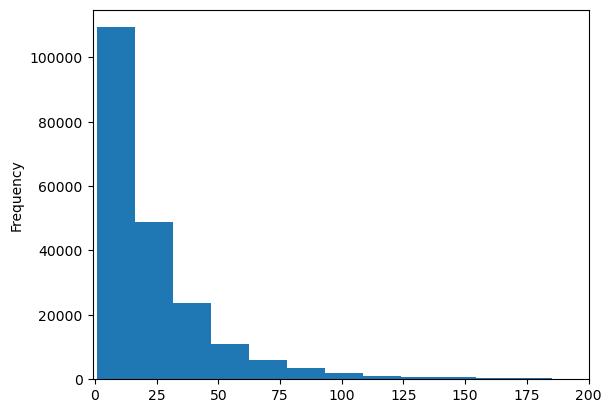

In [64]:
ax = merged.sum(axis=1).plot.hist(bins=50,alpha=1)
ax.set_xlim(-1,200)

In [65]:
adata = anndata.AnnData(merged)
adata.X =csr_matrix(adata.X
anndata.AnnData.write(adata,"./FilteredPeakMotifHits/Mlig.filt_peak_motif_hits.h5ad")

## S. mediterranea 

In [ ]:
## cathepsin 
cathepsin_filtered_motifs = motif_filtration('../../pl_BPnet/celltype/cathepsin_Smbias/interpret_null/corrected.counts_scores.h5', 
                                             '../../pl_BPnet/celltype/cathepsin_Smbias/interpret_all/corrected.counts_scores.h5', 
                                             '../../motif_filtration/Smed.peak_Motifhits_20230130.tsv', 
                                             '../../pl_BPnet/itoverlap_overlap_all_filtered.narrowPeak', 
                                             '../../motif_filtration/Smed/cathepsin_motifs_SHAP.tsv',
                                             0.95,
                                             '../../motif_filtration/Smed/cathepsin_mean_motifs_SHAP_filtered_95.tsv')

## epidermal 
epidermal_filtered_motifs = motif_filtration('../../pl_BPnet/celltype/epidermal_Smbias/interpret_null/corrected.counts_scores.h5', 
                                             '../../pl_BPnet/celltype/epidermal_Smbias/interpret_all/corrected.counts_scores.h5', 
                                             '../../motif_filtration/Smed.peak_Motifhits_20230130.tsv', 
                                             '../../pl_BPnet/itoverlap_overlap_all_filtered.narrowPeak', 
                                             '../../motif_filtration/Smed/epidermal_motifs_SHAP.tsv',
                                             0.95,
                                             '../../motif_filtration/Smed/epidermal_mean_motifs_SHAP_filtered_95.tsv')
## intestine
intestine_filtered_motifs = motif_filtration('../../pl_BPnet/celltype/intestine_Smbias/interpret_null/corrected.counts_scores.h5', 
                                             '../../pl_BPnet/celltype/intestine_Smbias/interpret_all/corrected.counts_scores.h5', 
                                             '../../motif_filtration/Smed.peak_Motifhits_20230130.tsv', 
                                             '../../pl_BPnet/itoverlap_overlap_all_filtered.narrowPeak', 
                                             '../../motif_filtration/Smed/intestine_motifs_SHAP.tsv',
                                             0.95,
                                             '../../motif_filtration/Smed/intestine_mean_motifs_SHAP_filtered_95.tsv')

## muscle 
muscle_filtered_motifs = motif_filtration('../../pl_BPnet/celltype/muscle_Smbias/interpret_null/corrected.counts_scores.h5', 
                                             '../../pl_BPnet/celltype/muscle_Smbias/interpret_all/corrected.counts_scores.h5', 
                                             '../../motif_filtration/Smed.peak_Motifhits_20230130.tsv', 
                                             '../../pl_BPnet/itoverlap_overlap_all_filtered.narrowPeak', 
                                             '../../motif_filtration/Smed/muscle_motifs_SHAP.tsv',
                                             0.95,
                                             '../../motif_filtration/Smed/muscle_mean_motifs_SHAP_filtered_95.tsv')

## neoblast 
neoblast_filtered_motifs = motif_filtration('../../pl_BPnet/celltype/neoblast_Smbias/interpret_null/corrected.counts_scores.h5', 
                                             '../../pl_BPnet/celltype/neoblast_Smbias/interpret_all/corrected.counts_scores.h5', 
                                             '../../motif_filtration/Smed.peak_Motifhits_20230130.tsv', 
                                             '../../pl_BPnet/itoverlap_overlap_all_filtered.narrowPeak', 
                                             '../../motif_filtration/Smed/neoblast_motifs_SHAP.tsv',
                                             0.95,
                                             '../../motif_filtration/Smed/neoblast_mean_motifs_SHAP_filtered_95.tsv')

## neoblast_GSC
neoblast_GSC_filtered_motifs = motif_filtration('../../pl_BPnet/celltype/neoblast_GSC_Smbias/interpret_null/corrected.counts_scores.h5', 
                                             '../../pl_BPnet/celltype/neoblast_GSC_Smbias/interpret_all/corrected.counts_scores.h5', 
                                             '../../motif_filtration/Smed.peak_Motifhits_20230130.tsv', 
                                             '../../pl_BPnet/itoverlap_overlap_all_filtered.narrowPeak', 
                                             '../../motif_filtration/Smed/neoblast_GSC_motifs_SHAP.tsv',
                                             0.95,
                                             '../../motif_filtration/Smed/neoblast_GSC_mean_motifs_SHAP_filtered_95.tsv')

## neural 
neural_filtered_motifs = motif_filtration('../../pl_BPnet/celltype/neural_Smbias/interpret_null/corrected.counts_scores.h5', 
                                             '../../pl_BPnet/celltype/neural_Smbias/interpret_all/corrected.counts_scores.h5', 
                                             '../../motif_filtration/Smed.peak_Motifhits_20230130.tsv', 
                                             '../../pl_BPnet/itoverlap_overlap_all_filtered.narrowPeak', 
                                             '../../motif_filtration/Smed/neural_motifs_SHAP.tsv',
                                             0.95,
                                             '../../motif_filtration/Smed/neural_mean_motifs_SHAP_filtered_95.tsv')

## pharynx_proto_ophis_progeny_paren 
five_type_filtered_motifs = motif_filtration('../../pl_BPnet/celltype/pharynx_proto_ophis_progeny_paren/interpret_null/corrected.counts_scores.h5', 
                                             '../../pl_BPnet/celltype/pharynx_proto_ophis_progeny_paren/interpret_all/corrected.counts_scores.h5', 
                                             '../../motif_filtration/Smed.peak_Motifhits_20230130.tsv', 
                                             '../../pl_BPnet/itoverlap_overlap_all_filtered.narrowPeak', 
                                             '../../motif_filtration/Smed/pharynx_proto_ophis_progeny_paren_motifs_SHAP.tsv',
                                             0.95,
                                             '../../motif_filtration/Smed/pharynx_proto_ophis_progeny_paren_mean_motifs_SHAP_filtered_95.tsv')

In [3]:
a = cathepsin_filtered_motifs.groupby(['key','peak_index']).size()
a.name = 'cathepsin' 

b = intestine_filtered_motifs.groupby(['key','peak_index']).size()
b.name = 'intestine'

c = muscle_filtered_motifs.groupby(['key','peak_index']).size()
c.name = 'muscle'

d = neoblast_filtered_motifs.groupby(['key','peak_index']).size()
d.name = 'neoblast'

e = neural_filtered_motifs.groupby(['key','peak_index']).size()
e.name = 'neural'

f = epidermal_filtered_motifs.groupby(['key','peak_index']).size()
f.name = 'epidermal'

g = neoblast_GSC_filtered_motifs.groupby(['key','peak_index']).size()
g.name = 'neoblast_GSC'

h = five_type_filtered_motifs.groupby(['key','peak_index']).size()
h.name = 'five_type'


In [4]:
merged = pd.concat( (a,b,c,d,e,f,g,h), axis=1 )
merged = merged.fillna(0).max(1).unstack(fill_value=0)

In [5]:
merged

peak_index,0,1,2,4,5,6,7,8,9,10,...,317329,317330,317331,317332,317333,317334,317335,317336,317338,317339
key,,,,,,,,,,,,,,,,,,,,,
JC_0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JC_0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JC_0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JC_0003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JC_0004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WC_2047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WC_2048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WC_2049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
merged[merged > 0] = 1


In [7]:
merged

peak_index,0,1,2,4,5,6,7,8,9,10,...,317329,317330,317331,317332,317333,317334,317335,317336,317338,317339
key,,,,,,,,,,,,,,,,,,,,,
JC_0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JC_0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JC_0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JC_0003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JC_0004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WC_2047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WC_2048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WC_2049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
pNames = {}
lNames = []
with open( '../../motif_filtration/Smed/all_interpret.bed', 'r' ) as f:
    for i, line in enumerate( f.readlines() ):
        l = line.strip().split()
        pNames[i] = l[0]+':'+l[1]+'-'+l[2]
        lNames.append(l[0]+':'+l[1]+'-'+l[2])

In [124]:
merged.columns = [ pNames[i] for i in merged.columns ]


In [125]:
merged = merged.T

In [126]:
merged

key,JC_0000,JC_0001,JC_0002,JC_0003,JC_0004,JC_0005,JC_0006,JC_0007,JC_0008,JC_0009,...,WC_2042,WC_2043,WC_2044,WC_2045,WC_2046,WC_2047,WC_2048,WC_2049,WC_2050,WC_2051
dd_Smes_g4_1:7589-7935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dd_Smes_g4_1:8522-9081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dd_Smes_g4_1:9260-9542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dd_Smes_g4_1:11396-11701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dd_Smes_g4_1:12320-12509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dd_Smes_g4_99:2423898-2424280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dd_Smes_g4_99:2442857-2443360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dd_Smes_g4_99:2444199-2444348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dd_Smes_g4_99:2448388-2448551,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(-1.0, 20.0)

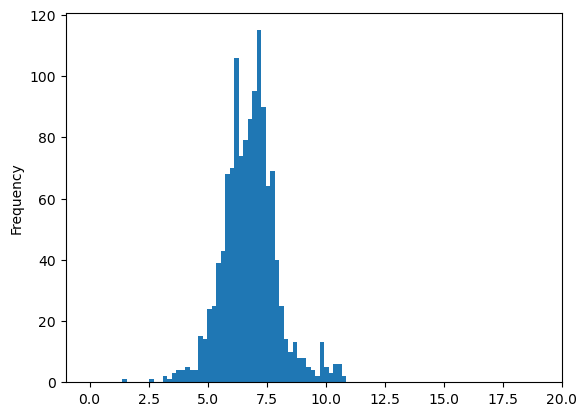

In [21]:
ax = np.log(merged.sum(axis=1)).plot.hist(bins=50,alpha=1)
ax.set_xlim(-1,20)


In [129]:
adata = anndata.AnnData(merged)
adata.X =csr_matrix(adata.X)
anndata.AnnData.write(adata,"./FilteredPeakMotifHits/Smed.filt_peak_motif_hits.h5ad")

## S. mansoni

In [ ]:
## cathepsin 
cathepsin_filtered_motifs = motif_filtration('../../BPnet_09_21_22/chrombpnet_model/fold_4/cathepsin/interpret_null/corrected.counts_scores.h5', 
                                             '../../BPnet_09_21_22/chrombpnet_model/fold_4/cathepsin/interpret_all/corrected.counts_scores.h5', 
                                             '../../BPnet_09_21_22/Sman.peak_Motifhits_20230130.tsv', 
                                             '../../BPnet_09_21_22/regeneration/itoverlap_overlap_all.narrowPeak', 
                                             '../../motif_filtration/schisto/cathepsin_motifs_SHAP.tsv',
                                             0.98,
                                             '../../motif_filtration/schisto/cathepsin_mean_motifs_SHAP_filtered_98.tsv')

## GSC
GSC_filtered_motifs = motif_filtration('../../BPnet_09_21_22/chrombpnet_model/fold_4/GSC_512_9_75/interpret_null/corrected.counts_scores.h5', 
                                       '../../BPnet_09_21_22/chrombpnet_model/fold_4/GSC_512_9_75/interpret_all/corrected.counts_scores.h5' 
                                       '../../BPnet_09_21_22/Sman.peak_Motifhits_20230130.tsv', 
                                       '../../BPnet_09_21_22/regeneration/itoverlap_overlap_all.narrowPeak',
                                       '../../motif_filtration/schisto/GSC_motifs_SHAP.tsv',
                                       0.98,
                                       '../../motif_filtration/schisto/GSC_mean_motifs_SHAP_filtered_98.tsv')

## intestine
intestine_filtered_motifs = motif_filtration('../../BPnet_09_21_22/chrombpnet_model/fold_4/intestine_512_9_75/interpret_null/corrected.counts_scores.h5', 
                                       '../../BPnet_09_21_22/chrombpnet_model/fold_4/intestine_512_9_75/interpret_all/corrected.counts_scores.h5' 
                                       '../../BPnet_09_21_22/Sman.peak_Motifhits_20230130.tsv', 
                                       '../../BPnet_09_21_22/regeneration/itoverlap_overlap_all.narrowPeak',
                                       '../../motif_filtration/schisto/intestine_motifs_SHAP.tsv',
                                       0.98,
                                       '../../motif_filtration/schisto/intestine_mean_motifs_SHAP_filtered_98.tsv')

## muscle
muscle_filtered_motifs = motif_filtration('../../BPnet_09_21_22/chrombpnet_model/fold_4/muscle_encode_old_muscle/interpret_null/corrected.counts_scores.h5', 
                                       '../../BPnet_09_21_22/chrombpnet_model/fold_4/muscle_encode_old_muscle/interpret_all/corrected.counts_scores.h5' 
                                       '../../BPnet_09_21_22/Sman.peak_Motifhits_20230130.tsv', 
                                       '../../BPnet_09_21_22/regeneration/itoverlap_overlap_all.narrowPeak',
                                       '../../motif_filtration/schisto/muscle_motifs_SHAP.tsv',
                                       0.98,
                                       '../../motif_filtration/schisto/muscle_mean_motifs_SHAP_filtered_98.tsv')

## neoblast 
neoblast_filtered_motifs = motif_filtration('../../BPnet_09_21_22/chrombpnet_model/fold_4/neoblast_old_muscle/interpret_null/corrected.counts_scores.h5', 
                                       '../../BPnet_09_21_22/chrombpnet_model/fold_4/neoblast_old_muscle/interpret_all/corrected.counts_scores.h5' 
                                       '../../BPnet_09_21_22/Sman.peak_Motifhits_20230130.tsv', 
                                       '../../BPnet_09_21_22/regeneration/itoverlap_overlap_all.narrowPeak',
                                       '../../motif_filtration/schisto/neoblast_motifs_SHAP.tsv',
                                       0.98,
                                       '../../motif_filtration/schisto/neoblast_mean_motifs_SHAP_filtered_98.tsv')

## neural 
neural_filtered_motifs = motif_filtration('../../BPnet_09_21_22/chrombpnet_model/fold_4/neural_encode_old_muscle/interpret_null/corrected.counts_scores.h5', 
                                       '../../BPnet_09_21_22/chrombpnet_model/fold_4/neural_encode_old_muscle/interpret_all/corrected.counts_scores.h5' 
                                       '../../BPnet_09_21_22/Sman.peak_Motifhits_20230130.tsv', 
                                       '../../BPnet_09_21_22/regeneration/itoverlap_overlap_all.narrowPeak',
                                       '../../motif_filtration/schisto/neural_motifs_SHAP.tsv',
                                       0.98,
                                       '../../motif_filtration/schisto/neural_mean_motifs_SHAP_filtered_98.tsv')

## oeso_proto
oeso_proto_filtered_motifs = motif_filtration('../../BPnet_09_21_22/chrombpnet_model/fold_4/oeso_proto_old_muscle/interpret_null/corrected.counts_scores.h5', 
                                       '../../BPnet_09_21_22/chrombpnet_model/fold_4/oeso_proto_old_muscle/interpret_all/corrected.counts_scores.h5' 
                                       '../../BPnet_09_21_22/Sman.peak_Motifhits_20230130.tsv', 
                                       '../../BPnet_09_21_22/regeneration/itoverlap_overlap_all.narrowPeak',
                                       '../../motif_filtration/schisto/oeso_proto_motifs_SHAP.tsv',
                                       0.98,
                                       '../../motif_filtration/schisto/oeso_proto_mean_motifs_SHAP_filtered_98.tsv')

## S1_vitellocyte
S1_vitellocyte_filtered_motifs = motif_filtration('../../BPnet_09_21_22/chrombpnet_model/fold_4/S1_vitellocyte_old_muscle/interpret_null/corrected.counts_scores.h5', 
                                       '../../BPnet_09_21_22/chrombpnet_model/fold_4/S1_vitellocyte_old_muscle/interpret_all/corrected.counts_scores.h5' 
                                       '../../BPnet_09_21_22/Sman.peak_Motifhits_20230130.tsv', 
                                       '../../BPnet_09_21_22/regeneration/itoverlap_overlap_all.narrowPeak',
                                       '../../motif_filtration/schisto/S1_vitellocyte_motifs_SHAP.tsv',
                                       0.98,
                                       '../../motif_filtration/schisto/S1_vitellocyte_mean_motifs_SHAP_filtered_98.tsv')


## tegument 
tegument_filtered_motifs = motif_filtration('../../BPnet_09_21_22/chrombpnet_model/fold_4/tegument_encode_old_muscle/interpret_null/corrected.counts_scores.h5', 
                                       '../../BPnet_09_21_22/chrombpnet_model/fold_4/tegument_encode_old_muscle/interpret_all/corrected.counts_scores.h5' 
                                       '../../BPnet_09_21_22/Sman.peak_Motifhits_20230130.tsv', 
                                       '../../BPnet_09_21_22/regeneration/itoverlap_overlap_all.narrowPeak',
                                       '../../motif_filtration/schisto/tegument_motifs_SHAP.tsv',
                                       0.98,
                                       '../../motif_filtration/schisto/tegument_mean_motifs_SHAP_filtered_98.tsv')


In [52]:
a = GSC_filtered_motifs.groupby(['key','peak_index']).size()
a.name = 'GSC'

b = cathepsin_filtered_motifs.groupby(['key','peak_index']).size()
b.name = 'cathepsin' 

c = intestine_filtered_motifs.groupby(['key','peak_index']).size()
c.name = 'intestine'

d = muscle_filtered_motifs.groupby(['key','peak_index']).size()
d.name = 'muscle'

e = neoblast_filtered_motifs.groupby(['key','peak_index']).size()
e.name = 'neoblast'

f = neural_filtered_motifs.groupby(['key','peak_index']).size()
f.name = 'neural'

g = oeso_proto_filtered_motifs.groupby(['key','peak_index']).size()
g.name = 'oeso_proto'

h = S1_vitellocyte_filtered_motifs.groupby(['key','peak_index']).size()
h.name = 'S1_vitellocyte'

i= tegument_filtered_motifs.groupby(['key','peak_index']).size()
i.name = 'tegument'


In [53]:
merged = pd.concat( (a,b,c,d,e,f,g,h,i), axis=1 )
merged = merged.fillna(0).max(1).unstack(fill_value=0)

In [54]:
merged

peak_index,0,1,3,4,5,6,7,8,9,10,...,163268,163269,163270,163271,163272,163274,163275,163276,163277,163278
key,,,,,,,,,,,,,,,,,,,,,
JC_0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
JC_0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JC_0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JC_0003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JC_0004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WC_2047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WC_2048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WC_2049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
merged[merged > 0] = 1


In [95]:
merged

peak_index,1,2,3,4,5,7,8,9,10,11,...,163267,163268,163269,163270,163271,163272,163274,163275,163276,163278
key,,,,,,,,,,,,,,,,,,,,,
JC_0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
JC_0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JC_0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JC_0003,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JC_0004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WC_2047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WC_2048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WC_2049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
pNames = {}
lNames = []
with open( '../../motif_filtration/schisto/all_interpret.bed', 'r' ) as f:
    for i, line in enumerate( f.readlines() ):
        l = line.strip().split()
        pNames[i] = l[0]+':'+l[1]+'-'+l[2]
        lNames.append(l[0]+':'+l[1]+'-'+l[2])

In [56]:
merged.columns = [ pNames[i] for i in merged.columns ]


In [57]:
merged = merged.T

(-1.0, 200.0)

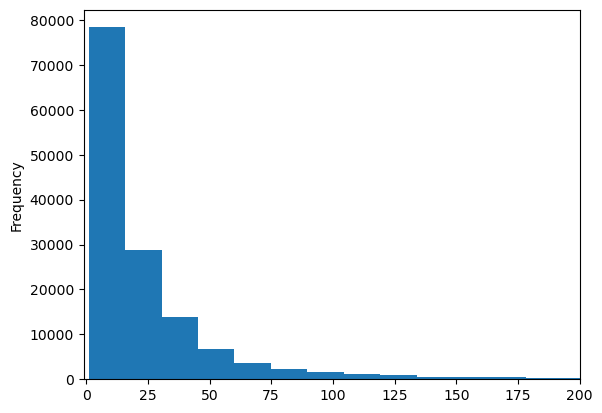

In [58]:
ax = merged.sum(axis=1).plot.hist(bins=100,alpha=1)
ax.set_xlim(-1,200)

In [59]:
adata = anndata.AnnData(merged)
adata.X =csr_matrix(adata.X)
anndata.AnnData.write(adata,"./FilteredPeakMotifHits/Sman.filt_peak_motif_hits.h5ad")

## H. Vulgaris

In [ ]:
PN_nGreen = motif_filtration_bulk('../hydra/bpnet_model/PN_nGreen_09_16_3/interpret_null/PN_nGreen_1.counts_scores.h5',
                                  '../hydra/bpnet_model/PN_nGreen_09_16_3/interpret_all/PN_nGreen_1.counts_scores.h5',
                                  '../hydra/bpnet_model/PN_nGreen_fold_2/interpret_null/PN_nGreen_2.counts_scores.h5', 
                                  '../hydra/bpnet_model/PN_nGreen_fold_2/interpret_all/PN_nGreen_2.counts_scores.h5',
                                  './hydra.peak_Motifhits_20240113.tsv', 
                                  '../hydra/bpnet_model/PN_nGreen_09_16_3/interpret_all/PN_nGreen_1.interpreted_regions.bed', 
                                  'hydra.peak_Motifhits_PN_nGreen.tsv',
                                  0.95,
                                  'hydra_peak_Motifhits_PN_nGreen_95_filtered.tsv')

whole_animal = motif_filtration_bulk('../hydra/bpnet_model/whole_fold_3/interpret_null/whole_fold_3.counts_scores.h5',
                                     '../hydra/bpnet_model/whole_fold_3/interpret_all/whole_fold_3.counts_scores.h5',
                                     '../hydra/bpnet_model/whole_fold_4_new/interpret_null/whole_fold_4.counts_scores.h5', 
                                     '../hydra/bpnet_model/whole_fold_4_new/interpret_all/whole_fold_4.counts_scores.h5',
                                     './hydra.peak_Motifhits_20240113.tsv', 
                                     '../hydra/bpnet_model/whole_fold_3/interpret_all/whole_fold_3.interpreted_regions.bed', 
                                     'hydra.peak_Motifhits_whole.tsv',
                                     0.95,
                                     'hydra_peak_Motifhits_whole_95_filtered.tsv')

In [40]:
a = PN_nGreen.groupby(['key','peak_index']).size()
a.name = 'PN_nGreen'

b = whole_animal.groupby(['key','peak_index']).size()
b.name = 'whole' 

In [41]:
merged = pd.concat( (a,b), axis=1 )
merged = merged.fillna(0).max(1).unstack(fill_value=0)

In [42]:
pNames = {}
lNames = []
with open( '../hydra/bpnet_model/PN_nGreen_09_16_3/interpret_all/PN_nGreen_1.interpreted_regions.bed', 'r' ) as f:
    for i, line in enumerate( f.readlines() ):
        l = line.strip().split()
        pNames[i] = l[0]+':'+l[1]+'-'+l[2]
        lNames.append(l[0]+':'+l[1]+'-'+l[2])

In [43]:
merged.columns = [ pNames[i] for i in merged.columns ]


In [44]:
merged = merged.T

In [45]:
merged

key,JC_0000|BIM2(0.105),JC_0001|Pax2(0.321),JC_0002|br(0.006),JC_0003|br(var.2)(0.000),JC_0004|HCM1(0.290),JC_0005|Foxq1(0.530),JC_0006|MOT2(0.189),JC_0007|usp(0.031),JC_0008|Ddit3--Cebpa(0.667),JC_0009|PBF(0.050),...,WC_2042|PBX1(3.504),WC_2043|ONECUT1(2.676),WC_2044|ASCL1(var.2)(7.196),WC_2045|HIF1A(4.822),WC_2046|SIX1(1.885),WC_2047|USF2(3.437),WC_2048|MSANTD3(6.715),WC_2049|CUP2(5.215),WC_2050|ZSCAN4(5.930),WC_2051|SCRT2(4.452)
chr-1:19317-19596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr-1:23652-23887,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr-1:28630-29025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr-1:32857-33074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr-1:41548-42588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr-9:63780894-63781452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr-9:63782476-63783678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr-9:63784683-63785163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr-9:63786031-63786239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
merged.to_csv('hydra_peak_motif_SHAP_95_mean_filtered.tsv',sep="\t")

In [47]:
## Making a peak file such that it only has the peaks in the SHAP filtered matrix 
# Here I can just use interpret regions file to overlap the summit 
all_peaks = pd.read_csv("../hydra/bpnet_model/PN_nGreen_09_16_3/interpret_all/PN_nGreen_1.interpreted_regions.bed",sep="\t",header=None)
all_peaks.columns = ['peak_chrom','peak_start','peak_end','Peak_index','score','strand','X','Y','Z','summit']


In [48]:
all_peaks['peak'] = all_peaks['peak_chrom']+':'+all_peaks['peak_start'].astype(str)+"-"+all_peaks['peak_end'].astype(str)
all_peaks

,peak_chrom,peak_start,peak_end,Peak_index,score,strand,X,Y,Z,summit,peak
0,chr-1,19317,19596,Peak_37579,151,.,2.03653,15.19487,13.21130,114,chr-1:19317-19596
1,chr-1,23652,23887,Peak_22601,499,.,3.51063,49.94364,47.71563,107,chr-1:23652-23887
2,chr-1,28630,29025,Peak_21245,597,.,3.77113,59.78931,57.51650,119,chr-1:28630-29025
3,chr-1,32857,33074,Peak_25763,513,.,3.17381,51.37158,49.18667,98,chr-1:32857-33074
4,chr-1,41548,42588,Peak_3838,5642,.,13.06937,564.23401,561.09271,680,chr-1:41548-42588
...,...,...,...,...,...,...,...,...,...,...,...
47544,chr-9,63780894,63781452,Peak_63,10676,.,17.22282,1067.61670,1062.65112,174,chr-9:63780894-63781452
47545,chr-9,63782476,63783678,Peak_5451,4119,.,6.32211,411.97220,408.95639,847,chr-9:63782476-63783678
47546,chr-9,63784683,63785163,Peak_1833,8652,.,13.62474,865.21594,861.72162,369,chr-9:63784683-63785163
47547,chr-9,63786031,63786239,Peak_10970,871,.,5.14241,87.14271,84.43577,96,chr-9:63786031-63786239


In [49]:
all_peaks = all_peaks[all_peaks['peak'].isin(merged.index)]

In [50]:
all_peaks.to_csv("./FilteredPeakMotifHits/Hv.filt_peak_motif_hits.tsv", sep='\t', header=False, index=False)

(-1.0, 200.0)

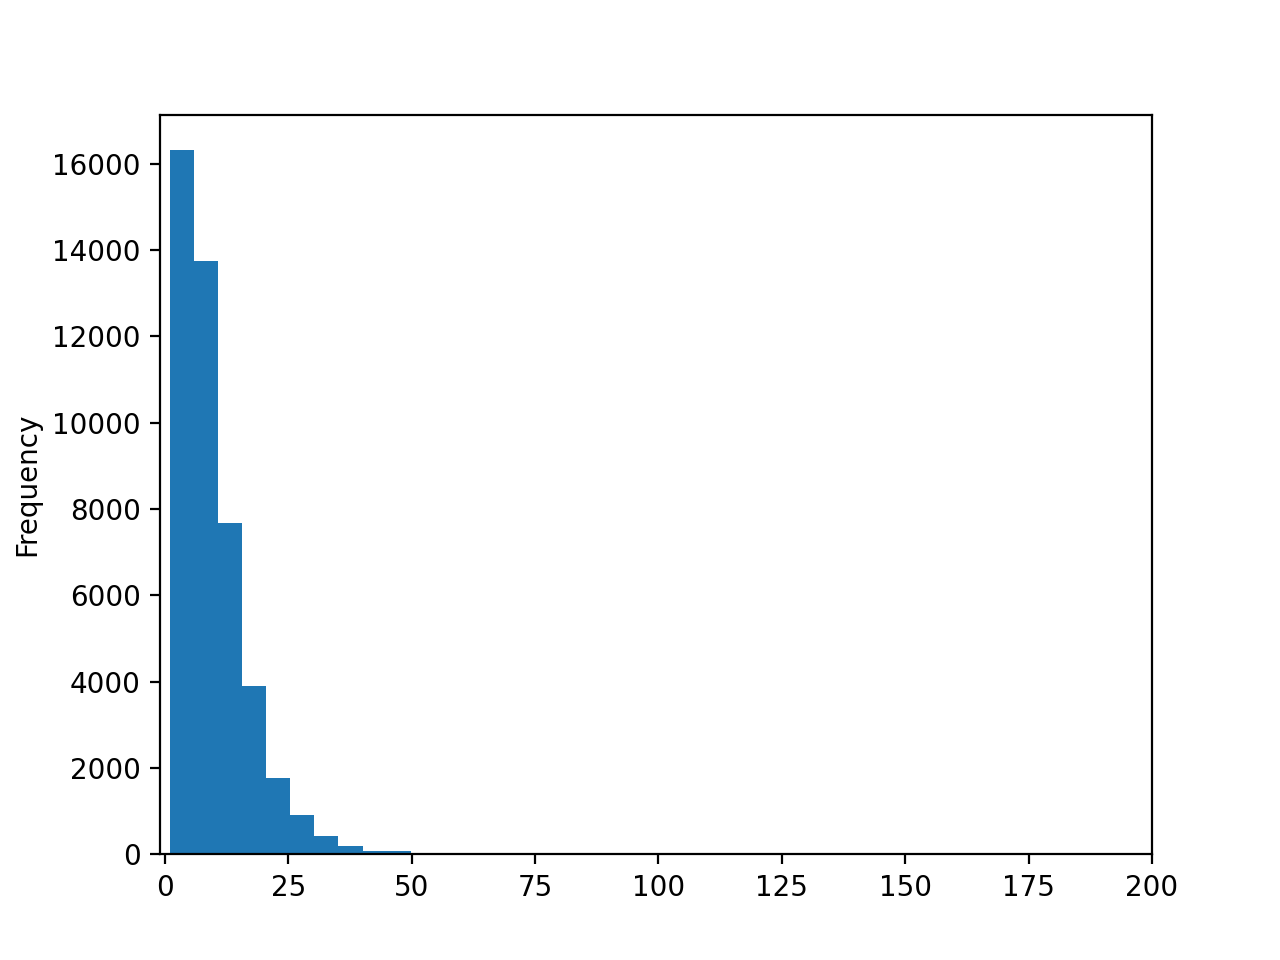

In [51]:
ax = merged.sum(axis=1).plot.hist(bins=50,alpha=1)
ax.set_xlim(-1,200)

## N. vectensis

In [ ]:
ELAV_positive = motif_filtration_bulk('./NV/bpnet_model/ELAV_positive_09_18/interpret_null/ELAV_pos_09_18.counts_scores.h5',
                                 './NV/bpnet_model/ELAV_positive_09_18/interpret_all/ELAV_pos.counts_scores.h5',
                                 './NV/bpnet_model/ELAV_pos_fold_2/interpret_null/ELAV_pos_fold_2.counts_scores.h5',
                                 './NV/bpnet_model/ELAV_pos_fold_2/interpret_all/ELAV_pos_fold2.counts_scores.h5',
                                 './NV.peak_Motifhits_20240113.tsv', 
                                 './NV/bpnet_model/ELAV_positive_09_18/interpret_all/ELAV_pos.interpreted_regions.bed', 
                                 'NV.peak_Motifhits_ELAV_positive.tsv',
                                  0.90,
                                 'NV_peak_Motifhits_ELAV_positive_95_filtered.tsv')

ELAV_negative = motif_filtration_bulk('./NV/bpnet_model/ELAV_neg_fold_2/interpret_null/ELAV_neg_fold_2.counts_scores.h5',
                                 './NV/bpnet_model/ELAV_neg_fold_2/interpret_all/ELAV_neg_fold_2.counts_scores.h5',
                                 './NV/bpnet_model/ELAV_neg_fold1/interpret_null/ELAV_neg_fold_1.counts_scores.h5',
                                 './NV/bpnet_model/ELAV_neg_fold1/interpret_all/ELAV_neg_fold_1.counts_scores.h5',
                                 './NV.peak_Motifhits_20240113.tsv', 
                                 './NV/bpnet_model/ELAV_neg_fold_2/interpret_all/ELAV_neg_fold_2.interpreted_regions.bed', 
                                 'NV.peak_Motifhits_ELAV_negative.tsv',
                                  0.90,
                                 'NV_peak_Motifhits_ELAV_negative_95_filtered.tsv')

In [24]:
a = ELAV_positive.groupby(['key','peak_index']).size()
a.name = 'ELAV_pos'

b = ELAV_negative.groupby(['key','peak_index']).size()
b.name = 'ELAV_neg' 

In [25]:
merged = pd.concat( (a,b), axis=1 )
merged = merged.fillna(0).max(1).unstack(fill_value=0)

In [28]:
pNames = {}
lNames = []
with open( './NV/bpnet_model/ELAV_positive_09_18/interpret_all/ELAV_pos.interpreted_regions.bed', 'r' ) as f:
    for i, line in enumerate( f.readlines() ):
        l = line.strip().split()
        pNames[i] = l[0]+':'+l[1]+'-'+l[2]
        lNames.append(l[0]+':'+l[1]+'-'+l[2])

In [29]:
merged.columns = [ pNames[i] for i in merged.columns ]


In [30]:
merged = merged.T

In [31]:
merged

key,JC_0000|BIM2(0.105),JC_0001|Pax2(0.321),JC_0002|br(0.006),JC_0003|br(var.2)(0.000),JC_0004|HCM1(0.290),JC_0005|Foxq1(0.530),JC_0006|MOT2(0.189),JC_0007|usp(0.031),JC_0008|Ddit3--Cebpa(0.667),JC_0009|PBF(0.050),...,WC_2042|PBX1(3.504),WC_2043|ONECUT1(2.676),WC_2044|ASCL1(var.2)(7.196),WC_2045|HIF1A(4.822),WC_2046|SIX1(1.885),WC_2047|USF2(3.437),WC_2048|MSANTD3(6.715),WC_2049|CUP2(5.215),WC_2050|ZSCAN4(5.930),WC_2051|SCRT2(4.452)
chr1:30756-30973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1:36088-36254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1:54525-54996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1:55221-55654,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1:82707-82980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrUn9:43780-44097,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chrUn9:48109-48279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chrUn9:48356-48584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chrUn9:48839-49257,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
merged.to_csv('NV_peak_motif_SHAP_90_mean_filtered.tsv',sep="\t")

In [33]:
## Making a peak file such that it only has the peaks in the SHAP filtered matrix 
# Here I can just use interpret regions file to overlap the summit 
all_peaks = pd.read_csv("./NV/bpnet_model/ELAV_positive_09_18/interpret_all/ELAV_pos.interpreted_regions.bed",sep="\t",header=None)
all_peaks.columns = ['peak_chrom','peak_start','peak_end','Peak_index','score','strand','X','Y','Z','summit']


In [35]:
all_peaks['peak'] = all_peaks['peak_chrom']+':'+all_peaks['peak_start'].astype(str)+"-"+all_peaks['peak_end'].astype(str)
all_peaks

,peak_chrom,peak_start,peak_end,Peak_index,score,strand,X,Y,Z,summit,peak
0,chr1,23395,23553,Peak_18470,103,.,3.49404,10.37908,8.43302,79,chr1:23395-23553
1,chr1,29843,30150,Peak_7156,138,.,4.32591,13.83278,11.37314,214,chr1:29843-30150
2,chr1,30756,30973,Peak_6274,152,.,4.55974,15.25263,12.72250,111,chr1:30756-30973
3,chr1,31121,31284,Peak_18817,123,.,3.56992,12.35422,10.41625,82,chr1:31121-31284
4,chr1,36088,36254,Peak_14759,132,.,3.35036,13.20492,11.11219,79,chr1:36088-36254
...,...,...,...,...,...,...,...,...,...,...,...
48115,chrUn9,43780,44097,Peak_55,872,.,10.71130,87.25818,82.49992,124,chrUn9:43780-44097
48116,chrUn9,48109,48279,Peak_8895,160,.,3.81932,16.02185,13.66861,83,chrUn9:48109-48279
48117,chrUn9,48356,48584,Peak_9978,194,.,3.77143,19.42568,17.12136,110,chrUn9:48356-48584
48118,chrUn9,48839,49257,Peak_6569,273,.,4.82452,27.39194,24.85659,285,chrUn9:48839-49257


In [36]:
all_peaks = all_peaks[all_peaks['peak'].isin(merged.index)]

In [38]:
all_peaks.to_csv("./FilteredPeakMotifHits/Nv.filt_peak_motif_hits.tsv", sep='\t', header=False, index=False)

(-1.0, 200.0)

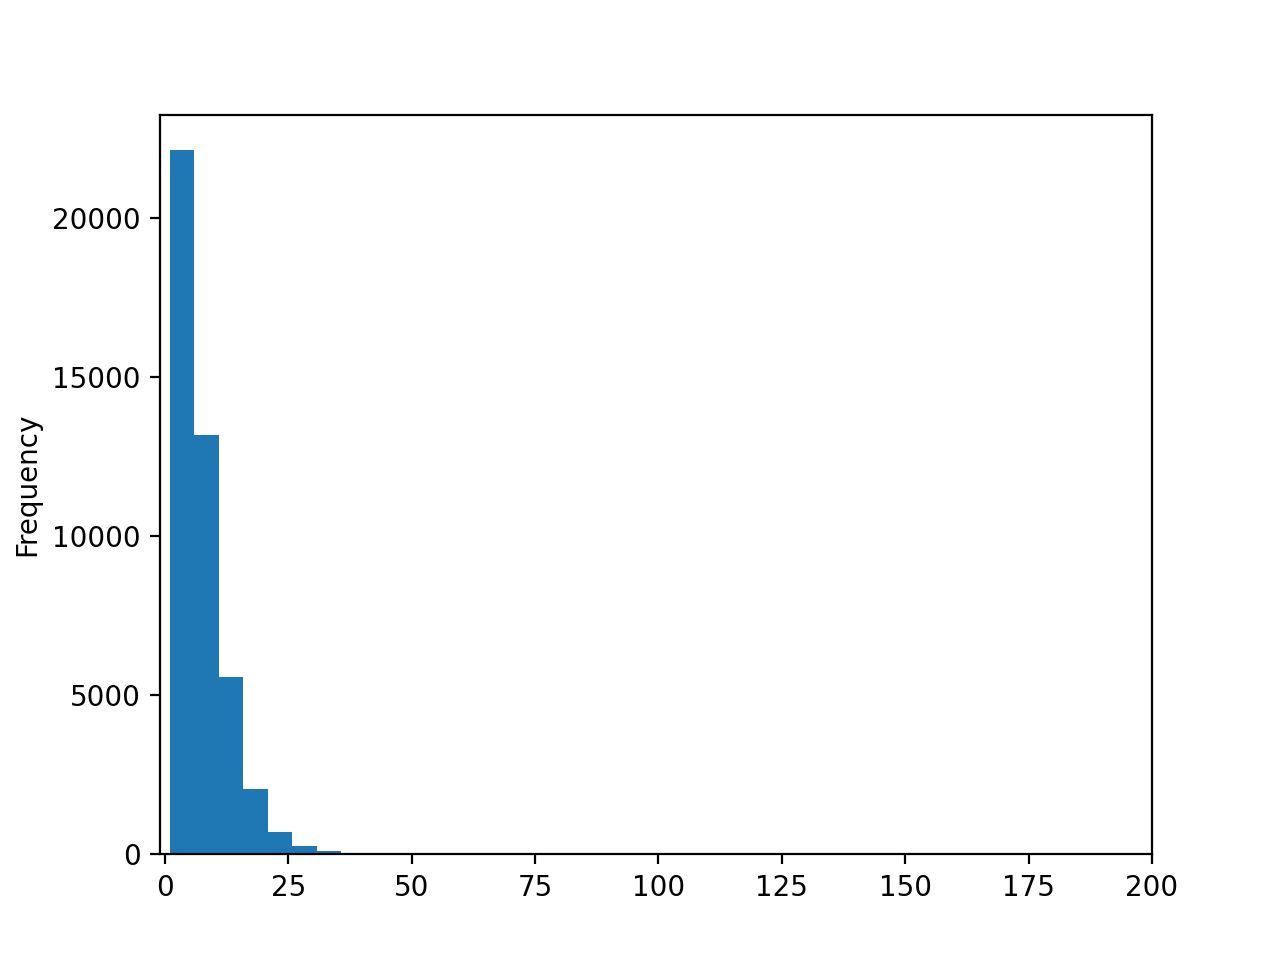

In [40]:
ax = merged.sum(axis=1).plot.hist(bins=50,alpha=1)
ax.set_xlim(-1,200)